In [8]:
# Forked from excellent kernel : https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features
# From Kaggler : https://www.kaggle.com/jsaguiar
# Just added a few features so I thought I had to make release it as well...

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import csv


In [20]:
lgb.__version__

'2.2.0'

In [42]:
final_df = pd.read_csv('../../datasets/homeCredit/BDSE12_03G_HomeCredit_V2.csv')
final_df = pd.get_dummies(final_df)

In [3]:
test_df = pd.read_csv('../../datasets/homeCredit/BDSE12_03G_HomeCredit_V2.csv')

In [6]:
def process_dataframe(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """

    # Label encode categoricals
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    categorical_feats = categorical_feats
    encoder_dict = {}
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
        encoder_dict[feat] = encoder

    return input_df, categorical_feats.tolist(), encoder_dict

In [10]:
test_df, categorical_feats, encoder_dict = process_dataframe(input_df=test_df)

In [7]:
#final_df = pd.read_csv('../../datasets/homeCredit/final_train_test.csv')

# LightGBM 模型

In [18]:
def kfold_lightgbm(df, num_folds = 5, stratified = True, debug= False, modeltype = 'goss', epoch = 2000):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM {}. Train shape: {}, test shape: {}".format(modeltype, train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                             label=train_df['TARGET'].iloc[train_idx], 
                             free_raw_data=False, silent=True)
        dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx], 
                             label=train_df['TARGET'].iloc[valid_idx], 
                             free_raw_data=False, silent=True)

        # LightGBM parameters found by Bayesian optimization
        params = {
            'objective': 'binary',
            'boosting_type': modeltype,
            'nthread': 5,
            'learning_rate': 0.013803211212539657,  # 0.02,
            'num_leaves': 20, #20,33
            'colsample_bytree': 0.9497036,
            'subsample': 0.5381263969882377, #0.8715623,
            'subsample_freq': 0,
            'max_depth': 8, #8,7
            'reg_alpha': 0.6618734111073816, #0.041545473,
            'reg_lambda': 0.320433363007782, #0.0735294,
            'min_split_gain': 0.07276947619457204,#0.0222415
            'min_child_weight': 57.725650927715265, # 60,39
            'seed': 564,
            'verbose': 1000,
            'metric': 'auc',
#             'device' : 'gpu',
#             'gpu_platform_id': 0,
#             'gpu_device_id':0
        }
        
        clf = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=epoch,
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds=200,
            verbose_eval=1000
        )

        oof_preds[valid_idx] = clf.predict(dvalid.data)
        sub_preds += clf.predict(test_df[feats]) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold {:2d} AUC : {:.6f}'.format(n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
        print()
        del clf, dtrain, dvalid
        gc.collect()

    print('Full AUC score : {:.6f}'.format(roc_auc_score(train_df['TARGET'], oof_preds)))
    # Write submission file and plot feature importance
    if not debug:
        sub_df = test_df[['SK_ID_CURR']].copy()
        sub_df['TARGET'] = sub_preds
        sub_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_LightGBM.csv', index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout
    plt.savefig('lgbm_importances01.png')

Starting LightGBM goss. Train shape: (307511, 798), test shape: (48744, 798)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.825563	valid_1's auc: 0.793763
[2000]	training's auc: 0.854628	valid_1's auc: 0.796142
Early stopping, best iteration is:
[2733]	training's auc: 0.871335	valid_1's auc: 0.796563
Fold  1 AUC : 0.796576

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.825978	valid_1's auc: 0.788935
[2000]	training's auc: 0.855102	valid_1's auc: 0.791908
Early stopping, best iteration is:
[2512]	training's auc: 0.867196	valid_1's auc: 0.792268
Fold  2 AUC : 0.792269

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.8259	valid_1's auc: 0.789635
[2000]	training's auc: 0.85494	valid_1's auc: 0.793148
[3000]	training's auc: 0.877436	valid_1's auc: 0.793994
Early stopping, best iteration is:
[3048]	training's auc: 0.878414	valid_1's auc: 0.794053
Fold  3 AUC : 0.794066



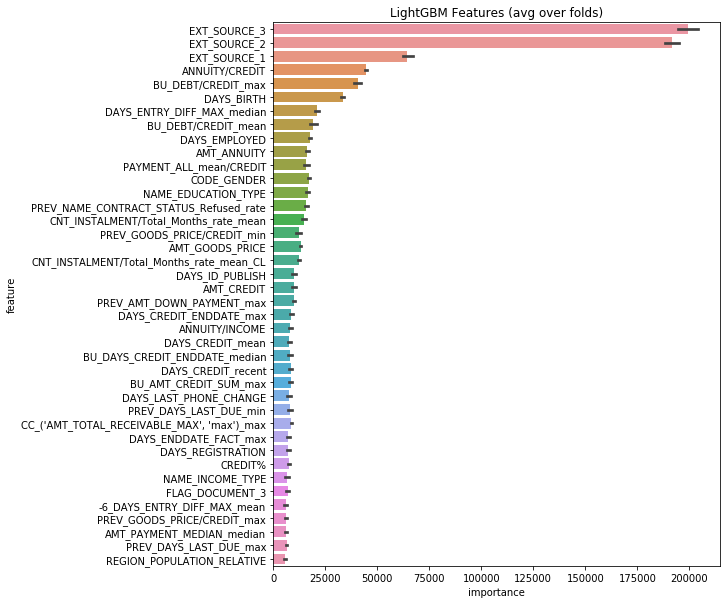

In [19]:
init_time = time.time()
kfold_lightgbm(test_df, 5, modeltype = 'goss', epoch = 5000)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：gbdt

Starting LightGBM gbdt. Train shape: (307511, 932), test shape: (48744, 932)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.824042	valid_1's auc: 0.793296
[2000]	training's auc: 0.851562	valid_1's auc: 0.795033
[3000]	training's auc: 0.873116	valid_1's auc: 0.795777
Early stopping, best iteration is:
[3426]	training's auc: 0.881261	valid_1's auc: 0.795899
Fold  1 AUC : 0.795909

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.824102	valid_1's auc: 0.787374
[2000]	training's auc: 0.851172	valid_1's auc: 0.790429
[3000]	training's auc: 0.873493	valid_1's auc: 0.790747
Early stopping, best iteration is:
[3759]	training's auc: 0.888024	valid_1's auc: 0.791048
Fold  2 AUC : 0.791043

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.823888	valid_1's auc: 0.789375
[2000]	training's auc: 0.851452	valid_1's auc: 0.792295
[3000]	training's auc: 0.873098	valid_1's auc: 0.793298


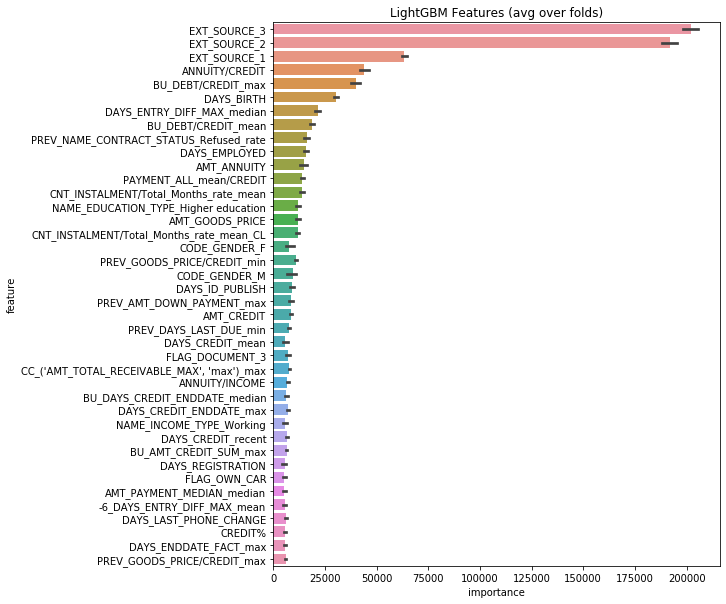

In [58]:
init_time = time.time()
kfold_lightgbm(final_df, 5, modeltype = 'gbdt', epoch = 5000)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：goss

Starting LightGBM goss. Train shape: (307511, 932), test shape: (48744, 932)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.826049	valid_1's auc: 0.793471
[2000]	training's auc: 0.856739	valid_1's auc: 0.795816
Early stopping, best iteration is:
[2316]	training's auc: 0.864569	valid_1's auc: 0.796191
Fold  1 AUC : 0.796179

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.826795	valid_1's auc: 0.78814
[2000]	training's auc: 0.857476	valid_1's auc: 0.791316
Early stopping, best iteration is:
[2633]	training's auc: 0.872932	valid_1's auc: 0.791881
Fold  2 AUC : 0.791874

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.825915	valid_1's auc: 0.789642
[2000]	training's auc: 0.856793	valid_1's auc: 0.793003
Early stopping, best iteration is:
[2308]	training's auc: 0.864688	valid_1's auc: 0.79353
Fold  3 AUC : 0.793541

Training until validation scores don't improve for 200 

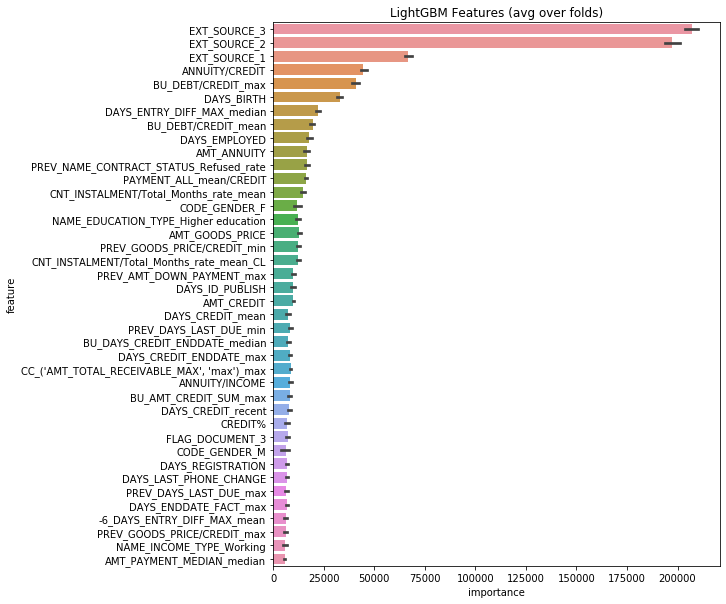

In [59]:
init_time = time.time()
kfold_lightgbm(final_df, 5, modeltype = 'goss', epoch = 5000)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：dart

Starting LightGBM dart. Train shape: (307511, 932), test shape: (48744, 932)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.773744	valid_1's auc: 0.764442
[2000]	training's auc: 0.801764	valid_1's auc: 0.782345
[3000]	training's auc: 0.817426	valid_1's auc: 0.789251
[4000]	training's auc: 0.830723	valid_1's auc: 0.792529
[5000]	training's auc: 0.842823	valid_1's auc: 0.794676
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.842823	valid_1's auc: 0.794676
Fold  1 AUC : 0.794670

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.775499	valid_1's auc: 0.760305
[2000]	training's auc: 0.802964	valid_1's auc: 0.778547
[3000]	training's auc: 0.818251	valid_1's auc: 0.785531
[4000]	training's auc: 0.831281	valid_1's auc: 0.789103
[5000]	training's auc: 0.843275	valid_1's auc: 0.791158
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.843275	valid_1's auc: 0.791158
Fold 

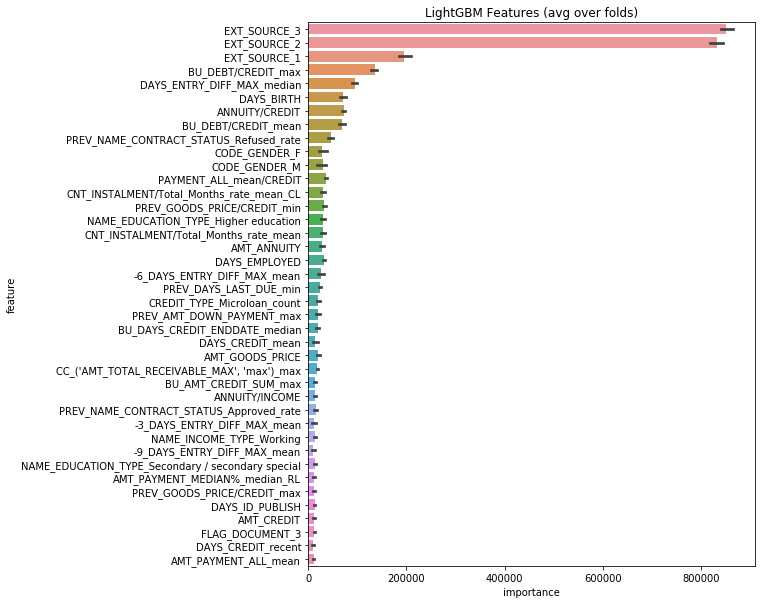

In [60]:
init_time = time.time()
kfold_lightgbm(final_df, 5, modeltype = 'dart', epoch = 5000)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：rf

Starting LightGBM rf. Train shape: (307511, 932), test shape: (48744, 932)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[227]	training's auc: 0.7222	valid_1's auc: 0.720019
Fold  1 AUC : 0.720019

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[208]	training's auc: 0.723575	valid_1's auc: 0.719657
Fold  2 AUC : 0.719657

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[227]	training's auc: 0.724123	valid_1's auc: 0.713323
Fold  3 AUC : 0.713323

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[31]	training's auc: 0.721529	valid_1's auc: 0.723186
Fold  4 AUC : 0.723186

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[313]	training's auc: 0.724006	valid_1's auc: 0.715125
Fold  5 AUC : 0.715125

Full AUC score : 0.716943
Elapsed time=520.

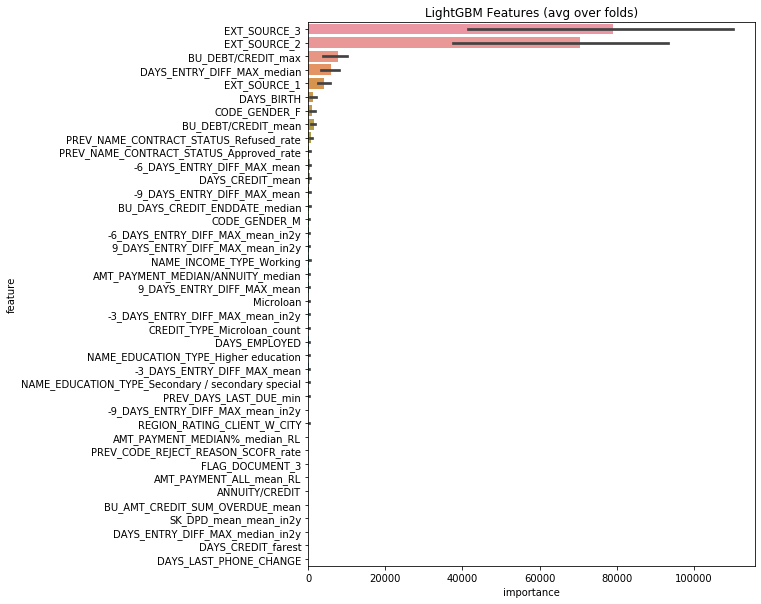

In [63]:
init_time = time.time()
kfold_lightgbm(final_df, 5, modeltype = 'rf', epoch = 5000)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

# XGBoost 模型

In [3]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [4]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle

In [23]:
def kfold_xgb(df, num_folds, stratified = True, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting XGBoost. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        #if n_fold == 0: # REmove for full K-fold run
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = XGBClassifier(learning_rate =0.01, 
                            n_estimators=5000, 
                            max_depth=4, 
                            min_child_weight=5,
#                             tree_method='gpu_hist',
                            subsample=0.8, 
                            colsample_bytree=0.8, 
                            objective= 'binary:logistic',
                            nthread=4,
                            scale_pos_weight=2.5,
                            seed=28,
                            reg_lambda = 1.2)
        
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)
        
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats])[:, 1] # / folds.n_splits # - Uncomment for K-fold 

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

        np.save("xgb_oof_preds_1", oof_preds)
        np.save("xgb_sub_preds_1", sub_preds)
        
        cuda.select_device(0)
        cuda.close()
        
    
    clf = pickle.load(open('test.pickle','rb'))
    # print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_XGBoost_GPU.csv', index= False)
    #display_importances(feature_importance_df)
    #return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBoost Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('xgb_importances02.png')

In [17]:
init_time = time.time()
kfold_xgb(final_df, 5)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

Starting XGBoost. Train shape: (307507, 871), test shape: (48744, 871)
[0]	validation_0-auc:0.72139	validation_1-auc:0.719406
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1000]	validation_0-auc:0.801304	validation_1-auc:0.782099
[2000]	validation_0-auc:0.824016	validation_1-auc:0.788724
[3000]	validation_0-auc:0.840526	validation_1-auc:0.790976
[4000]	validation_0-auc:0.853685	validation_1-auc:0.791867
[4999]	validation_0-auc:0.865639	validation_1-auc:0.792425
Fold  1 AUC : 0.792440
[0]	validation_0-auc:0.722441	validation_1-auc:0.714728
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1000]	validation_0-auc:0.802008	validation_1-auc:0.778002
[2000]	validation_0-auc:0.824956	validation_1-auc:0.78592
[3000]	validation_0-auc:0.841242	validation_1-auc:0.788808
[4000]	v

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Elapsed time=62182.09 sec.
